<a href="https://colab.research.google.com/github/Mefoolyhi/PHA-Biodegradation/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

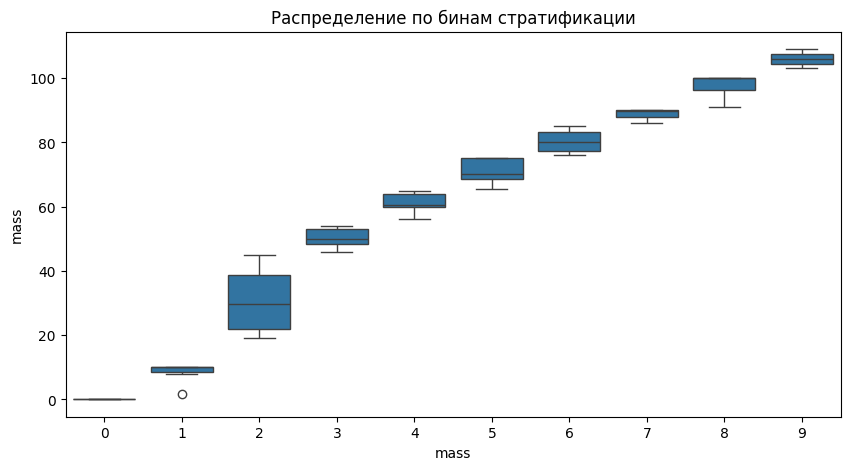

Original y: [100.   95.   90.   85.   80.   75.   70.   65.   60.  100.   98.   96.
  94.   92.   90.   88.   86.   84.   90.   80.   70.   60.   98.   90.
  80.   70.   95.   85.   75.   65.   95.   85.   75.   65.   80.   60.
  40.   20.   75.   50.   30.   10.  100.   97.   94.   91.   88.   85.
  82.   79.   76.  100.   99.   98.   97.   96.   95.   94.   93.   92.
  77.5  77.5  20.   33.   10.   20.   40.   37.5  60.   60.   25.  100.
 100.   75.   45.  100.  100.  100.  100.   63.   53.   27.   61.   53.
  29.   67.   54.   29.   66.   70.   64.   84.  109.   96.   77.   93.
  70.   45.   39.   88.   94.   74.   80.   75.   37.   40.   29.   76.
  88.   47.   62.   56.   22.   21.   19.   80.   50.   64.   34.   40.
  40.  100.  100.  100.  100.   75.   65.  100.  100.   58.   22.   20.
 100.  100.  100.  100.  100.  100.  100.  100.   64.9  92.5  97.  100.
 100.  100.  100.  100.    0.    0.   92.5 100.  100.   71.7  59.4  48.3
 100.   87.6  71.8  62.9 100.   82.6  72.4  66.  10

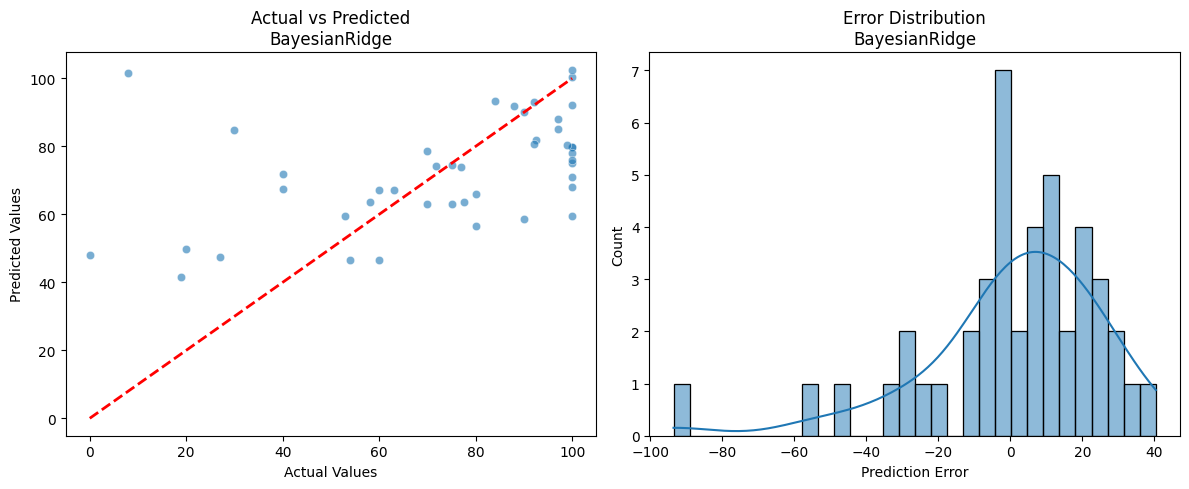

NameError: name 'y_val' is not defined

<Figure size 1500x600 with 0 Axes>

In [ ]:
#baesan ridge
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor  # Возвращаем GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (mean_absolute_error, r2_score,
                           median_absolute_error, mean_squared_error)
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, TargetEncoder, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression, Ridge  # Для Platt Scaling
from sklearn.preprocessing import PolynomialFeatures  # Для Beta Calibration
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

train_df = pd.read_excel('preprocessed_train.xlsx')

X = train_df.drop(columns=['mass'])
y = train_df['mass']

bins = [-1, 1, 10, 45, 55, 65, 75, 85, 90, 100, 110]
y_binned = pd.cut(y, bins=bins, labels=False, duplicates='drop')

plt.figure(figsize=(10, 5))
sns.boxplot(x=y_binned, y=y)
plt.title('Распределение по бинам стратификации')
plt.show()

print("Original y:", y.values)
print("Binned y:  ", y_binned.values)
bin_counts = y_binned.value_counts().sort_index()
print(bin_counts)

# Пайплайн для препроцессинга
numerical_cols = ['% second component', 'day', 'ph']
categorical_cols = ['type of pha', 'environment', 'form', 'dimensionality',
                    'porosity', 'in vivo', 'enzymatic']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('robust', RobustScaler()),
            ('scaler', Normalizer())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_cols)
    ])

X_preprocessed = preprocessor.fit_transform(X, y)

X_train, X_test, y_train, y_test, y_train_binned, y_test_binned = train_test_split(
    X_preprocessed, y, y_binned,
    test_size=0.2,
    random_state=42,
    stratify=y_binned,
)


adasyn = ADASYN(sampling_strategy='minority',
                n_neighbors=1,
                random_state=42)

X_train_resampled, y_train_resampled_binned = adasyn.fit_resample(X_train, y_train_binned)


bin_centers = []
for i in range(len(bins) - 1):
    lower = bins[i]
    upper = bins[i + 1]
    median_val = (lower + upper) / 2
    bin_centers.append(median_val)

y_train_resampled = np.array([bin_centers[int(cls)] for cls in y_train_resampled_binned])

print("\nРаспределение после ADASYN (только на тренировочных данных):")
print(pd.Series(y_train_resampled_binned).value_counts().sort_index())

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train_resampled_binned
)
from sklearn.linear_model import BayesianRidge
from scipy.stats import loguniform

# Определяем параметры для перебора
param_dist = {
    'alpha_1': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
    'alpha_2': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
    'lambda_1': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
    'lambda_2': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
    'max_iter': [100, 200, 300, 400, 500],
    'tol': [1e-3, 1e-4, 1e-5]
}

# Создаем модель BayesianRidge
bayesian_ridge = BayesianRidge(compute_score=True)

# Настраиваем RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=bayesian_ridge,
    param_distributions=param_dist,
    n_iter=50,  # Количество комбинаций параметров для проверки
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Обучение модели с подбором параметров
random_search.fit(X_train_resampled, y_train_resampled)

# Выводим лучшие параметры
print("Лучшие параметры:", random_search.best_params_)

# Используем лучшую модель
best_bayesian_ridge = random_search.best_estimator_



# Метрики
def print_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse_val = rmse(y_true, y_pred)
    print(f"\n{model_name} результаты:")
    print(f"{'Метрика':<15}{'Значение':<15}")
    print(f"{'MAE':<15}{mae:.4f}")
    print(f"{'MedAE':<15}{medae:.4f}")
    print(f"{'R²':<15}{r2:.4f}")
    print(f"{'RMSE':<15}{rmse_val:.4f}")
    return mae





# Визуализация результатов
def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r', linewidth=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted\n{title}')

    plt.subplot(1, 2, 2)
    errors = y_true - y_pred
    sns.histplot(errors, kde=True, bins=30)
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.title(f'Error Distribution\n{title}')

    plt.tight_layout()
    plt.show()

# Предсказания на тестовых данных
y_pred_test_br = best_bayesian_ridge.predict(X_test)

# Оценка качества
print_metrics(y_test, y_pred_test_br, "BayesianRidge (test)")

# Визуализация результатов
plot_results(y_test, y_pred_test_br, "BayesianRidge")

# Сравнение первых 20 образцов
plt.figure(figsize=(15, 6))
sample_indices = range(min(20, len(y_val)))
plt.plot(sample_indices, y_val[sample_indices], 'o-', label='Actual', markersize=8)
plt.plot(sample_indices, y_pred_val_base[sample_indices], 's--', label='Base Predicted', markersize=6)
plt.plot(sample_indices, y_pred_val_cal[sample_indices], 'd--', label='Calibrated Predicted', markersize=6)
plt.xlabel('Sample Index')
plt.ylabel('Mass')
plt.title('Comparison of Actual and Predicted Values for First 20 Samples')
plt.legend()
plt.grid(True)
plt.show()

train_errors = abs(y_train_resampled - y_pred_train_cal)
test_errors = abs(y_test - y_pred_test_cal)
val_errors = abs(y_val - y_pred_val_cal)

# 1. Сначала получим названия всех фичей после препроцессинга
num_features = numerical_cols
cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = list(num_features) + list(cat_features)

# 2. Создадим функцию для сопоставления индексов
def get_original_indices(X_resampled, X_original):
    """Находит соответствие между сэмплами после ADASYN и оригинальными данными"""
    from sklearn.neighbors import NearestNeighbors

    # Находим ближайших соседей для сгенерированных сэмплов
    nbrs = NearestNeighbors(n_neighbors=1).fit(X_original)
    _, indices = nbrs.kneighbors(X_resampled)

    return indices.flatten()

# 3. Получаем индексы оригинальных данных для train выборки
original_indices = get_original_indices(X_train_resampled, X_preprocessed)

# 4. Создаем DataFrame с ошибками для train
train_df_with_errors = pd.DataFrame(X_train_resampled, columns=all_feature_names)
train_df_with_errors['True_Value'] = y_train_resampled
train_df_with_errors['Predicted'] = y_pred_train_cal
train_df_with_errors['Absolute_Error'] = train_errors

# 5. Добавляем оригинальные категориальные признаки
for col in categorical_cols:
    train_df_with_errors[col] = train_df.iloc[original_indices][col].values

# 6. Аналогично для test (если нужно)
test_df_with_errors = pd.DataFrame(X_test, columns=all_feature_names)
test_df_with_errors['True_Value'] = y_test
test_df_with_errors['Predicted'] = y_pred_test_cal
test_df_with_errors['Absolute_Error'] = test_errors

val_df_with_errors = pd.DataFrame(X_val, columns=all_feature_names)
val_df_with_errors['True_Value'] = y_val
val_df_with_errors['Predicted'] = y_pred_val_cal
val_df_with_errors['Absolute_Error'] = val_errors

# 7. Функция для вывода топ ошибок
def print_top_errors(error_df, title, n=10):
    top_errors = error_df.sort_values('Absolute_Error', ascending=False).head(n)
    print(f"\n{title} (топ-{n} наибольших ошибок):")
    cols_to_show = ['True_Value', 'Predicted', 'Absolute_Error']
    print(top_errors[cols_to_show])
    print("\nСредняя ошибка в топе:", top_errors['Absolute_Error'].mean())

# 8. Выводим результаты
print_top_errors(train_df_with_errors, "Обучающая выборка")
print_top_errors(test_df_with_errors, "Тестовая выборка")
print_top_errors(val_df_with_errors, "Диссертация")

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import(Dense, Conv1D, MaxPooling1D, Flatten,
                                    Dropout, BatchNormalization, LSTM)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import L2 as l2
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import(mean_absolute_error, median_absolute_error,
                            r2_score, mean_squared_error)
from sklearn.preprocessing import QuantileTransformer, OneHotEncoder, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN  # Заменяем SMOTE на ADASYN

train_df = pd.read_excel('/content/big_train_no_duples.xlsx')

X = train_df.drop(columns=['mass'])
y = train_df['mass']

def polynomial_decay_schedule(epoch, lr):
    power = 1.0
    max_epochs = 200
    return 3e-4 * (1 - epoch / max_epochs) ** power

#bins = [-1, 5, 20, 40, 70, 90, 99, 110]
quantiles = [0, 0.25, 0.5, 0.75, 1]
bins = [-1] + [y.quantile(q) for q in quantiles]
y_binned = pd.cut(y, bins=bins, labels=False, duplicates='drop')

numerical_cols = ['% second component', 'day', 'ph']
categorical_cols = ['type of pha', 'environment', 'form', 'dimensionality',
                    'porosity', 'in vivo', 'enzymatic', 'form_type', 'environment_type']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('custom', StandardScaler())
    ]), numerical_cols),
        ('cat', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_cols)
])

X_preprocessed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test, y_train_binned, y_test_binned = train_test_split(
    X_preprocessed, y, y_binned,
    test_size=0.2,
    random_state=42,
    stratify=y_binned,
)

adasyn = ADASYN(sampling_strategy='minority',  # Балансировать все классы
                n_neighbors=3,  # Количество соседей для генерации (аналог k_neighbors в SMOTE)
                random_state=42)

X_train_resampled, y_train_resampled_binned = adasyn.fit_resample(X_train, y_train_binned)

bin_centers = []
for i in range(len(bins) - 1):
    # Получаем все значения y в текущем бине
    lower = bins[i]
    upper = bins[i + 1]
    median_val = (lower + upper) / 2
    bin_centers.append(median_val)
y_train_resampled = np.array([bin_centers[int(cls)] for cls in y_train_resampled_binned])

# Compute sample weights for the resampled training data
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train_resampled_binned
)

X_train_processed = X_train_resampled
X_test_processed = X_test

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

X_train_3d = np.expand_dims(X_train_processed, axis=1)
X_test_3d = np.expand_dims(X_test_processed, axis=1)

def create_cnn_model(input_shape, architecture='medium'):
    model = Sequential()
    if architecture == 'simple':
        model.add(Conv1D(32, 1, activation='relu', input_shape=input_shape))
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1))
    elif architecture == 'medium':
        model.add(Conv1D(64, 1, activation='relu', input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(Conv1D(128, 1, activation='relu', kernel_regularizer=l2(1e-3)))
        model.add(BatchNormalization())
        model.add(Flatten())
        model.add(Dense(128, activation='relu', kernel_regularizer=l2(1e-3)))
        model.add(Dropout(0.3))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1))
    elif architecture == 'complex':
        model.add(Conv1D(64, 1, activation='relu', input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(Conv1D(128, 1, activation='relu', kernel_regularizer=l2(1e-3)))
        model.add(BatchNormalization())
        model.add(Conv1D(256, 1, activation='relu', kernel_regularizer=l2(1e-3)))
        model.add(BatchNormalization())
        model.add(Flatten())
        model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-3)))
        model.add(Dropout(0.4))
        model.add(Dense(128, activation='relu', kernel_regularizer=l2(1e-3)))
        model.add(Dropout(0.3))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1))
    optimizer = RMSprop(learning_rate=3e-4, rho=0.9)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

models_to_test = {
    'CNN_simple': lambda: create_cnn_model((X_train_3d.shape[1], X_train_3d.shape[2]), 'simple'),
    'CNN_medium': lambda: create_cnn_model((X_train_3d.shape[1], X_train_3d.shape[2]), 'medium'),
    'CNN_complex': lambda: create_cnn_model((X_train_3d.shape[1], X_train_3d.shape[2]), 'complex')
}

results = {}
for model_name, model_creator in models_to_test.items():

    # Callbacks
    callbacks = [
       #ReduceLROnPlateau(factor=0.1, patience=5, threshold=0.01, cooldown=0, min_lr=1e-6),
        LearningRateScheduler(polynomial_decay_schedule),

    ]

    model = model_creator()

    train_data = X_train_3d
    test_data = X_test_3d

    history = model.fit(
        train_data, y_train_resampled,  # Use the resampled y_train
        validation_data=(test_data, y_test),
        epochs=200,
        batch_size=64,
        callbacks=callbacks,
        sample_weight=sample_weights,
        verbose=1
    )

    val_df = pd.read_excel('/content/final_test.xlsx')

    X_val = val_df.drop(columns=['mass'])
    y_val = val_df['mass']
    X_val_preprocessed = preprocessor.transform(X_val)
    val_data = np.expand_dims(X_val_preprocessed, axis=1)

    y_pred_train = model.predict(train_data).flatten()
    y_pred_test = model.predict(test_data).flatten()
    y_pred_val = model.predict(val_data).flatten()

    metrics = {
        'MAE_train': mean_absolute_error(y_train_resampled, y_pred_train),
        'MAE_test': mean_absolute_error(y_test, y_pred_test),
        'MAE_val': mean_absolute_error(y_val, y_pred_val),
        'MedAE_train': median_absolute_error(y_train_resampled, y_pred_train),
        'MedAE_test': median_absolute_error(y_test, y_pred_test),
        'MedAE_val': median_absolute_error(y_val, y_pred_val),
        'R2_train': r2_score(y_train_resampled, y_pred_train),
        'R2_test': r2_score(y_test, y_pred_test),
        'R2_val': r2_score(y_val, y_pred_val),
        'RMSE_train': rmse(y_train_resampled, y_pred_train),
        'RMSE_test': rmse(y_test, y_pred_test),
        'RMSE_val': rmse(y_val, y_pred_val),
        'history': history
    }
    results[model_name] = metrics

    print(f"\nResults for {model_name} model:")
    print(f"{'Метрика':<15}{'Обучающая':<15}{'Тестовая':<15}{'Диссертация':<15}")
    print(f"{'MAE':<15}{metrics['MAE_train']:.4f}{'':<5}{metrics['MAE_test']:.4f}{'':<5}{metrics['MAE_val']:.4f}")
    print(f"{'MedAE':<15}{metrics['MedAE_train']:.4f}{'':<5}{metrics['MedAE_test']:.4f}{'':<5}{metrics['MedAE_val']:.4f}")
    print(f"{'R²':<15}{metrics['R2_train']:.4f}{'':<5}{metrics['R2_test']:.4f}{'':<5}{metrics['R2_val']:.4f}{'':<5}")
    print(f"{'RMSE':<15}{metrics['RMSE_train']:.4f}{'':<5}{metrics['RMSE_test']:.4f}{'':<5}{metrics['RMSE_val']:.4f}")

print("\nСравнение моделей:")
print(f"{'Модель':<15}{'MAE (test)':<15}{'MedAE (test)':<15}{'R² (test)':<15}{'RMSE (test)':<15}")
for model_name, metrics in results.items():
    print(f"{model_name:<15}{metrics['MAE_val']:.4f}{'':<5}{metrics['MedAE_val']:.4f}{'':<5}{metrics['R2_val']:.4f}{'':<5}{metrics['RMSE_val']:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - loss: 4324.8267 - mae: 54.7854 - val_loss: 5630.1943 - val_mae: 68.4604 - learning_rate: 3.0000e-04
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4373.5176 - mae: 56.1736 - val_loss: 5601.2622 - val_mae: 68.2603 - learning_rate: 2.9850e-04
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3674.8347 - mae: 50.2752 - val_loss: 5557.8916 - val_mae: 67.9690 - learning_rate: 2.9700e-04
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3547.2229 - mae: 49.8060 - val_loss: 5507.4849 - val_mae: 67.6310 - learning_rate: 2.9550e-04
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2863.2498 - mae: 43.8589 - val_loss: 5435.9414 - val_mae: 67.1502 - learning_rate: 2.9400e-04
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2605.7273 - mae: 41.8157 - val_loss: 5342.8984 - val_mae: 66.5188 - learning_rate: 2.9250e-04
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2305.5154 - mae: 39.1738 - va

In [ ]:
#PCA
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import QuantileTransformer, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.decomposition import PCA  # Import PCA
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt

# Load data (unchanged)
train_df = pd.read_excel('/content/big_train_no_duples.xlsx')
X = train_df.drop(columns=['mass'])
y = train_df['mass']

# Binning (unchanged)
quantiles = [0, 0.25, 0.5, 0.75, 1]
bins = [-1] + [y.quantile(q) for q in quantiles]
y_binned = pd.cut(y, bins=bins, labels=False, duplicates='drop')

# Define columns (unchanged)
numerical_cols = ['% second component', 'day', 'ph']
categorical_cols = ['type of pha', 'environment', 'form', 'dimensionality',
                   'porosity', 'in vivo', 'enzymatic', 'form_type', 'environment_type']

# Create preprocessing pipeline with PCA
preprocessor = Pipeline(steps=[
    ('col_transformer', ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler())
            ]), numerical_cols),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), categorical_cols)
        ]
    )),
    ('pca', PCA(n_components=0.95))  # Retain 95% of variance
])

# Apply preprocessing and PCA
X_preprocessed = preprocessor.fit_transform(X)

# Split data (unchanged)
X_train, X_test, y_train, y_test, y_train_binned, y_test_binned = train_test_split(
    X_preprocessed, y, y_binned,
    test_size=0.2,
    random_state=42,
    stratify=y_binned,
)

# Apply ADASYN (unchanged)
adasyn = ADASYN(sampling_strategy='minority', n_neighbors=3, random_state=42)
X_train_resampled, y_train_resampled_binned = adasyn.fit_resample(X_train, y_train_binned)

# Map binned classes to bin centers (unchanged)
bin_centers = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]
y_train_resampled = np.array([bin_centers[int(cls)] for cls in y_train_resampled_binned])

# Compute sample weights (unchanged)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_resampled_binned)

# Prepare data for CNN
X_train_processed = X_train_resampled
X_test_processed = X_test

# Reshape for CNN (adjust input shape based on PCA components)
X_train_3d = np.expand_dims(X_train_processed, axis=1)  # Shape: (samples, 1, n_components)
X_test_3d = np.expand_dims(X_test_processed, axis=1)

# Define RMSE (unchanged)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# CNN model (adjusted input shape)
def create_cnn_model(input_shape, architecture='medium'):
    model = Sequential()
    if architecture == 'simple':
        model.add(Conv1D(32, 1, activation='relu', input_shape=input_shape))
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1))
    elif architecture == 'medium':
        model.add(Conv1D(64, 1, activation='relu', input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(Conv1D(128, 1, activation='relu', kernel_regularizer=l2(1e-3)))
        model.add(BatchNormalization())
        model.add(Flatten())
        model.add(Dense(128, activation='relu', kernel_regularizer=l2(1e-3)))
        model.add(Dropout(0.3))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1))
    elif architecture == 'complex':
        model.add(Conv1D(64, 1, activation='relu', input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(Conv1D(128, 1, activation='relu', kernel_regularizer=l2(1e-3)))
        model.add(BatchNormalization())
        model.add(Conv1D(256, 1, activation='relu', kernel_regularizer=l2(1e-3)))
        model.add(BatchNormalization())
        model.add(Flatten())
        model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-3)))
        model.add(Dropout(0.4))
        model.add(Dense(128, activation='relu', kernel_regularizer=l2(1e-3)))
        model.add(Dropout(0.3))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1))
    optimizer = RMSprop(learning_rate=3e-4, rho=0.9)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Polynomial decay schedule (unchanged)
def polynomial_decay_schedule(epoch, lr):
    power = 1.0
    max_epochs = 200
    return 3e-4 * (1 - epoch / max_epochs) ** power

# Define models (adjusted input shape)
models_to_test = {
    'CNN_complex': lambda: create_cnn_model((X_train_3d.shape[1], X_train_3d.shape[2]), 'complex')
}

results = {}
for model_name, model_creator in models_to_test.items():
    # Callbacks (unchanged)
    callbacks = [
        LearningRateScheduler(polynomial_decay_schedule),
    ]

    model = model_creator()

    train_data = X_train_3d
    test_data = X_test_3d

    # Train model (unchanged)
    history = model.fit(
        train_data, y_train_resampled,
        validation_data=(test_data, y_test),
        epochs=200,
        batch_size=64,
        callbacks=callbacks,
        sample_weight=sample_weights,
        verbose=1
    )

    # Validation data (apply PCA)
    val_df = pd.read_excel('/content/final_test.xlsx')
    X_val = val_df.drop(columns=['mass'])
    y_val = val_df['mass']
    X_val_preprocessed = preprocessor.transform(X_val)  # Apply same preprocessing + PCA
    val_data = np.expand_dims(X_val_preprocessed, axis=1)

    # Predictions
    y_pred_train = model.predict(train_data).flatten()
    y_pred_test = model.predict(test_data).flatten()
    y_pred_val = model.predict(val_data).flatten()

    # Metrics (unchanged)
    metrics = {
        'MAE_train': mean_absolute_error(y_train_resampled, y_pred_train),
        'MAE_test': mean_absolute_error(y_test, y_pred_test),
        'MAE_val': mean_absolute_error(y_val, y_pred_val),
        'MedAE_train': median_absolute_error(y_train_resampled, y_pred_train),
        'MedAE_test': median_absolute_error(y_test, y_pred_test),
        'MedAE_val': median_absolute_error(y_val, y_pred_val),
        'R2_train': r2_score(y_train_resampled, y_pred_train),
        'R2_test': r2_score(y_test, y_pred_test),
        'R2_val': r2_score(y_val, y_pred_val),
        'RMSE_train': rmse(y_train_resampled, y_pred_train),
        'RMSE_test': rmse(y_test, y_pred_test),
        'RMSE_val': rmse(y_val, y_pred_val),
        'history': history
    }
    results[model_name] = metrics

    # Print results (unchanged)
    print(f"\nResults for {model_name} model:")
    print(f"{'Метрика':<15}{'Обучающая':<15}{'Тестовая':<15}{'Диссертация':<15}")
    print(f"{'MAE':<15}{metrics['MAE_train']:.4f}{'':<5}{metrics['MAE_test']:.4f}{'':<5}{metrics['MAE_val']:.4f}")
    print(f"{'MedAE':<15}{metrics['MedAE_train']:.4f}{'':<5}{metrics['MedAE_test']:.4f}{'':<5}{metrics['MedAE_val']:.4f}")
    print(f"{'R²':<15}{metrics['R2_train']:.4f}{'':<5}{metrics['R2_test']:.4f}{'':<5}{metrics['R2_val']:.4f}")
    print(f"{'RMSE':<15}{metrics['RMSE_train']:.4f}{'':<5}{metrics['RMSE_test']:.4f}{'':<5}{metrics['RMSE_val']:.4f}")

# Compare models (unchanged)
print("\nСравнение моделей:")
print(f"{'Модель':<15}{'MAE (test)':<15}{'MedAE (test)':<15}{'R² (test)':<15}{'RMSE (test)':<15}")
for model_name, metrics in results.items():
    print(f"{model_name:<15}{metrics['MAE_val']:.4f}{'':<5}{metrics['MedAE_val']:.4f}{'':<5}{metrics['R2_val']:.4f}{'':<5}{metrics['RMSE_val']:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - loss: 4637.7837 - mae: 56.8374 - val_loss: 5644.7734 - val_mae: 68.5652 - learning_rate: 3.0000e-04
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4416.2266 - mae: 55.4765 - val_loss: 5624.6929 - val_mae: 68.4247 - learning_rate: 2.9850e-04
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4179.7480 - mae: 54.1756 - val_loss: 5598.1816 - val_mae: 68.2415 - learning_rate: 2.9700e-04
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3908.9604 - mae: 51.7490 - val_loss: 5563.0166 - val_mae: 67.9996 - learning_rate: 2.9550e-04
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3901.2129 - mae: 52.2637 - val_loss: 5517.4697 - val_mae: 67.6880 - learning_rate: 2.9400e-04
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3405.4043 - mae: 48.7167 - val_loss: 5464.7681 - val_mae: 67.3269 - learning_rate: 2.9250e-04
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3156.1389 - mae: 46.5038 - va

In [ ]:
# Function to compute and print feature importance
def print_pca_feature_importance(preprocessor, numerical_cols, categorical_cols):
    # Get the ColumnTransformer and PCA steps
    col_transformer = preprocessor.named_steps['col_transformer']
    pca = preprocessor.named_steps['pca']

    # Get feature names after preprocessing
    num_features = numerical_cols
    cat_transformer = col_transformer.named_transformers_['cat']
    onehot_encoder = cat_transformer.named_steps['onehot']
    cat_features = onehot_encoder.get_feature_names_out(categorical_cols)
    all_features = list(num_features) + list(cat_features)

    # Get PCA loadings (components_ matrix)
    loadings = pca.components_.T  # Shape: (n_features, n_components)

    # Compute feature importance as weighted sum of squared loadings
    explained_variance = pca.explained_variance_  # Variance per component
    total_variance = np.sum(explained_variance)
    weights = explained_variance / total_variance  # Normalize weights

    # Importance is the sum of squared loadings, weighted by explained variance
    feature_importance = np.sum((loadings ** 2) * weights, axis=1)

    # Create a DataFrame for feature importance
    importance_df = pd.DataFrame({
        'Feature': all_features,
        'Importance': feature_importance
    })

    # Aggregate importance for categorical features (sum importance of one-hot encoded columns)
    aggregated_importance = []
    for col in numerical_cols + categorical_cols:
        if col in numerical_cols:
            # For numerical features, take the importance directly
            importance = importance_df[importance_df['Feature'] == col]['Importance'].sum()
            aggregated_importance.append((col, importance))
        else:
            # For categorical features, sum the importance of all one-hot encoded columns
            related_features = [f for f in all_features if f.startswith(f"{col}_")]
            importance = importance_df[importance_df['Feature'].isin(related_features)]['Importance'].sum()
            aggregated_importance.append((col, importance))

    # Create aggregated importance DataFrame
    agg_importance_df = pd.DataFrame(aggregated_importance, columns=['Feature', 'Importance'])

    # Sort by importance
    agg_importance_df = agg_importance_df.sort_values(by='Importance', ascending=False)

    # Print results
    print("\nPCA Feature Importance:")
    print(f"{'Feature':<30}{'Importance':<15}")
    print("-" * 45)
    for _, row in agg_importance_df.iterrows():
        print(f"{row['Feature']:<30}{row['Importance']:.6f}")

    return agg_importance_df

# Print feature importance
importance_df = print_pca_feature_importance(preprocessor, numerical_cols, categorical_cols)


PCA Feature Importance:
Feature                       Importance     
---------------------------------------------
environment                   0.185420
day                           0.132807
% second component            0.132625
ph                            0.132464
form                          0.127045
environment_type              0.100338
type of pha                   0.089464
in vivo                       0.065931
enzymatic                     0.062917
form_type                     0.042710
dimensionality                0.042041
porosity                      0.029286
